In [ ]:
import cv2
import os
# I have a video at path data/1.mp4. I want to extract frames at data/frames with a frequency of 1 frame per second.
def extract_frames(video_path, output_folder, fps=1):    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % fps == 0:
            frame_filename = os.path.join(output_folder, f"frame_{frame_count // fps:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
        frame_count += 1

extract_frames('data/9.mp4', 'data/video_frames_9', fps=1)

Test Dataset length: 3035


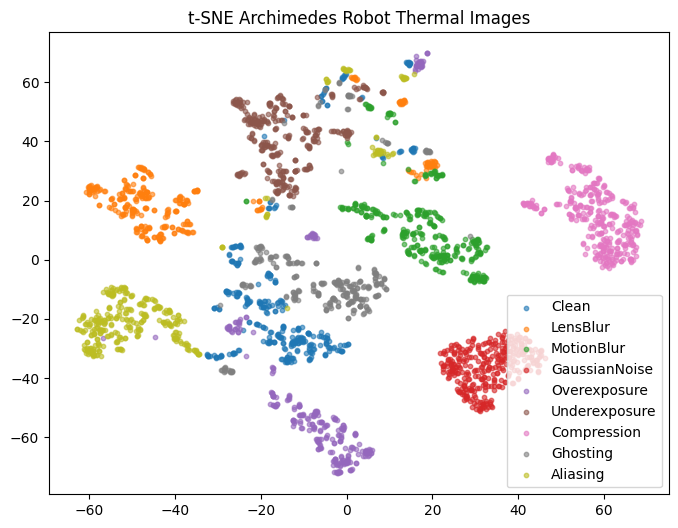

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from distortions import *
from datasets import ImageDataset
from models import IQAEncoder, extract_features
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
distortions = [Clean(), LensBlur(), MotionBlur(), GaussianNoise(), Overexposure(), Underexposure(), Compression(), Ghosting(), Aliasing()]
label_map = {distortion.__class__.__name__: i for i, distortion in enumerate(distortions)}
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # 224 or 384
    transforms.ToTensor(),
])

# load model from models path
def load_model(model_path, device):
    model = IQAEncoder(feature_dim=128, model_name='resnet50').to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

model = load_model('models/resnet50_128_out.pth', device)

# test the model with tsne at data/video_frames_1

image_folder = "data/video_frames_4"
# image_folder = "data/FLIR_ADAS_v2/images_thermal_val/data"
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(('.jpg', '.png'))]
test_dataset = ImageDataset(image_paths, distortions=distortions, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
print(f"Test Dataset length: {len(test_dataset)}")

test_features, test_labels = extract_features(model, test_dataloader, label_map, device)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(test_features.numpy())
plt.figure(figsize=(8, 6))
num_classes = len(label_map)
for i in range(num_classes):
    idx = test_labels.numpy() == i
    label_name = list(label_map.keys())[list(label_map.values()).index(i)]
    plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label_name, alpha=0.6, s=10)

plt.legend()
plt.title('t-SNE Archimedes Robot Thermal Images')
plt.savefig('tsne_distorted_images.png')
plt.show()